# Data Preprocessing

### Importazione librerie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


### Caricamento file train.csv

In [2]:
file_path = "../../train.csv"
df = pd.read_csv(file_path)

### Controllo  e rimozione valori nulli e duplicati

In [3]:
# Valori mancanti per ciascuna colonna
missing_values_per_column = df.isnull().sum()
print("\nValori mancanti nel DataFrame per ciascuna colonna:")
print(missing_values_per_column)

# Totale dei valori mancanti in tutto il DataFrame
total_missing_values = missing_values_per_column.sum()
print(f"\nTotale dei valori mancanti nel DataFrame:\n{total_missing_values}")


Valori mancanti nel DataFrame per ciascuna colonna:
Year    0
S0      0
S1      0
S2      0
S3      0
       ..
S85     0
S86     0
S87     0
S88     0
S89     0
Length: 91, dtype: int64

Totale dei valori mancanti nel DataFrame:
0


In [4]:
print("\nDuplicati nel DataFrame:")
print(df.duplicated().sum())


Duplicati nel DataFrame:
52


In [5]:
clean_df = df.dropna() 
clean_df = df.drop_duplicates()

In [6]:
# Verifica rimozione valori nulli e duplicati
total_missing_values = missing_values_per_column.sum()
print(f"\nTotale dei valori mancanti nel DataFrame: {total_missing_values}")
print(f"\nDuplicati nel DataFrame: {clean_df.duplicated().sum()}")


Totale dei valori mancanti nel DataFrame: 0

Duplicati nel DataFrame: 0


# Rimozione outlier e visualizzazione post rimozione

In [7]:
# Itera su ogni anno presente nel DataFrame
for year in clean_df['Year'].unique():
    # Filtra il DataFrame per l'anno corrente
    df_year = clean_df[clean_df['Year'] == year]
    
    # Calcola la mediana per ogni colonna
    median_values = df_year.median()
    
    # Calcola i limiti per individuare gli outlier per ogni colonna
    Q1 = df_year.quantile(0.25)
    Q3 = df_year.quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    # Sostituisci gli outlier con la mediana per ogni colonna
    def replace_outliers(row):
        for col in df_year.columns[1:]:  # Escludi la colonna 'year'
            if row[col] < lower_limit[col] or row[col] > upper_limit[col]:
                row[col] = median_values[col]
        return row
    
    df_year = df_year.apply(replace_outliers, axis=1) # Sostituzione outlier con mediana
    
    # Sostituisci i dati nel DataFrame originale
    clean_df.loc[clean_df['Year'] == year] = df_year

In [8]:
# Seleziona solo le colonne che iniziano con 'S'
colonne_s = [col for col in clean_df.columns if col.startswith('S')]

# Lista per memorizzare i risultati originali e nuovi
risultati_outliers = []
risultati_nuovi_outliers = []

# Ciclo attraverso ogni colonna 'S'
for col in colonne_s:
    # Calcola i quantili e l'IQR (Interquartile Range) per i dati originali
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    # Calcola i baffi inferiori e superiori
    baffo_inferiore = q1 - 1.5 * iqr
    baffo_superiore = q3 + 1.5 * iqr
    
    # Trova gli outliers inferiori e superiori per i dati originali
    outliers_inferiori = df[df[col] < baffo_inferiore]
    outliers_superiori = df[df[col] > baffo_superiore]
    numero_outliers = len(outliers_inferiori) + len(outliers_superiori)
    
    # Calcola la percentuale di outliers
    percentuale_outliers = (numero_outliers / len(df)) * 100
    
    # Aggiungi i risultati alla lista
    risultati_outliers.append({
        'Colonna': col,
        'Numero outliers': numero_outliers,
        'Percentuale outliers': f'{percentuale_outliers:.2f}%'
    })
    
    # Calcola i quantili e l'IQR (Interquartile Range) per i dati modificati
    q1_new = clean_df[col].quantile(0.25)
    q3_new = clean_df[col].quantile(0.75)
    iqr_new = q3_new - q1_new
    
    # Calcola i baffi inferiori e superiori per i dati modificati
    baffo_inferiore_new = q1_new - 1.5 * iqr_new
    baffo_superiore_new = q3_new + 1.5 * iqr_new
    
    # Trova gli outliers inferiori e superiori per i dati modificati
    outliers_inferiori_new = clean_df[clean_df[col] < baffo_inferiore_new]
    outliers_superiori_new = clean_df[clean_df[col] > baffo_superiore_new]
    numero_outliers_new = len(outliers_inferiori_new) + len(outliers_superiori_new)
    
    # Calcola la percentuale di nuovi outliers
    percentuale_outliers_new = (numero_outliers_new / len(clean_df)) * 100
    
    # Aggiungi i risultati alla lista dei nuovi outliers
    risultati_nuovi_outliers.append({
        'Colonna': col,
        'Numero nuovi outliers': numero_outliers_new,
        'Percentuale nuovi outliers': f'{percentuale_outliers_new:.2f}%'
    })

# Converti le liste in DataFrame
df_outliers = pd.DataFrame(risultati_outliers)
df_nuovi_outliers = pd.DataFrame(risultati_nuovi_outliers)

# Unisci i DataFrame sui risultati originali e nuovi
outliers_summary_df = df_outliers.merge(df_nuovi_outliers, on='Colonna')

# Visualizza la tabella finale
print(outliers_summary_df)


   Colonna  Numero outliers Percentuale outliers  Numero nuovi outliers  \
0       S0             5306                2.10%                   1492   
1       S1             7313                2.90%                   2684   
2       S2             7484                2.97%                   2657   
3       S3            11229                4.45%                   4782   
4       S4             5224                2.07%                   1429   
..     ...              ...                  ...                    ...   
85     S85            16608                6.59%                   8073   
86     S86            15876                6.30%                   7731   
87     S87            14794                5.87%                   7548   
88     S88            19031                7.55%                   9973   
89     S89            19330                7.67%                  10960   

   Percentuale nuovi outliers  
0                       0.59%  
1                       1.06%  
2  

### Suddivisione del DataSet

In [9]:
X = clean_df.drop(columns=['Year'])  # Non la consideriamo per il modello
y = clean_df['Year'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

### Standardizzazione

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Salva il modello di scaling
with open('scaler.save', 'wb') as f:
    pickle.dump(scaler, f)

In [11]:
training_set_size = X_train.shape[0]
test_set_size = X_test.shape[0]
total_size = X.shape[0]

print(f"Dimensione del training set: {training_set_size} ({(training_set_size / total_size) * 100:.2f}% del dataset totale)")
print(f"Dimensione del test set: {test_set_size} ({(test_set_size / total_size) * 100:.2f}% del dataset totale)")
# print("\nDati di training normalizzati:")
# print(X_train_scaled)

Dimensione del training set: 201698 (80.00% del dataset totale)
Dimensione del test set: 50425 (20.00% del dataset totale)


### PCA

In [12]:
X_rf = clean_df.drop('Year', axis=1)
y_rf = clean_df['Year']

In [13]:
# Riduzione della dimensionalità con PCA
pca = PCA(n_components=0.95)  # Mantieni il 95% della varianza spiegata
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Numero di componenti principali: {pca.n_components_}")
print(f"Forma dei dati di training dopo PCA: {X_train_pca.shape}")
print(f"Forma dei dati di test dopo PCA: {X_test_pca.shape}") 

Numero di componenti principali: 76
Forma dei dati di training dopo PCA: (201698, 76)
Forma dei dati di test dopo PCA: (50425, 76)


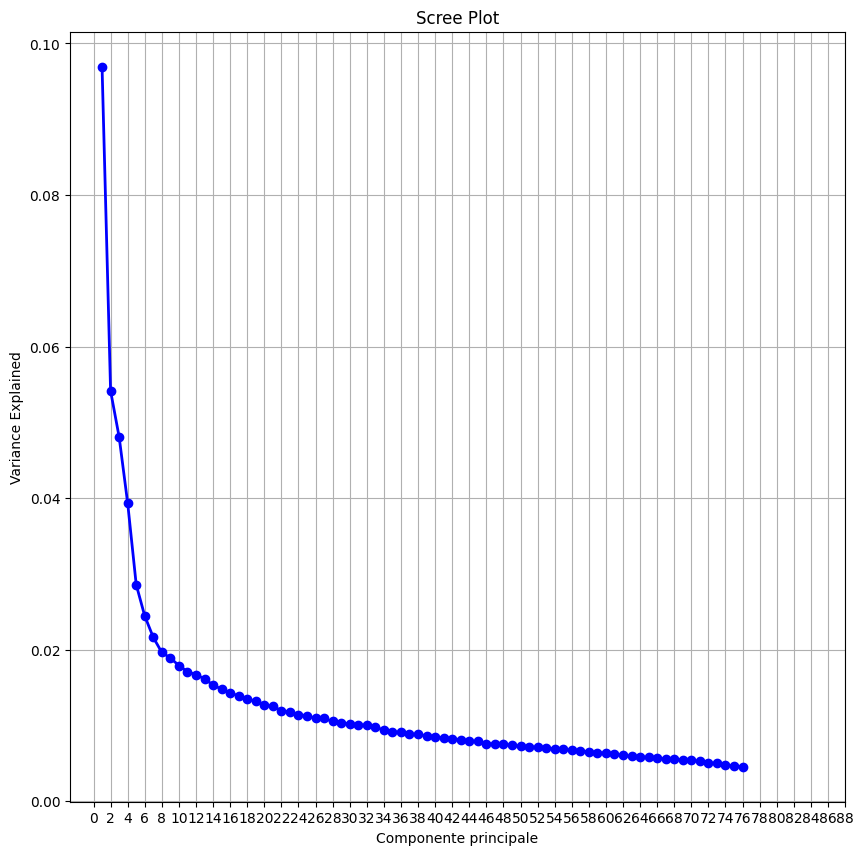

Explainer variance of each component: [0.09692469 0.05412895 0.04806441 0.03933065 0.02857302 0.02443236
 0.02161112 0.01961974 0.01890284 0.01788984 0.017096   0.01669412
 0.01615147 0.01531919 0.01478145 0.01432042 0.01386291 0.01341789
 0.01324431 0.01272169 0.0124973  0.01195174 0.01176963 0.01143497
 0.01126016 0.01094845 0.01091529 0.01052434 0.01033505 0.01021099
 0.01005563 0.01001322 0.00976837 0.00937    0.0091539  0.00906982
 0.00883007 0.00881955 0.00861228 0.00843029 0.0083641  0.00825738
 0.00809597 0.00790401 0.00788197 0.00758495 0.00756961 0.00750773
 0.00737644 0.00724875 0.00716583 0.00709692 0.00701649 0.00692097
 0.00688887 0.00669458 0.00663192 0.00653223 0.00640386 0.00632932
 0.0061705  0.00603308 0.00590975 0.00581946 0.00576287 0.00566026
 0.00557619 0.00552181 0.00541372 0.00540309 0.00525479 0.00506456
 0.00497037 0.00472363 0.00467908 0.0045433 ]
Varianza totale: 0.9530364539951103


In [14]:
#Scree Plot -> mostra la percentuale di variazione spiegata da ogni componente principale
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Componente principale')
plt.xticks(range(0,90,2))
plt.ylabel('Variance Explained')
plt.show()
print("Explainer variance of each component:",pca.explained_variance_ratio_)
print("Varianza totale:", sum(pca.explained_variance_ratio_))

# Modeling

In [15]:
# Calcolo e stampe metriche di valutazione del modello
def valutazione_modello(y_pred, y_true):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"MSE (Mean Squared Error): {mse}")
    print(f"MAE (Mean Absolute Error): {mae}")
    print(f"MAPE (Mean Absolute Percentage Error): {mape}%")
    print(f"R-squared: {r2}")
    #return mse, mae, mape, r2

## SVR

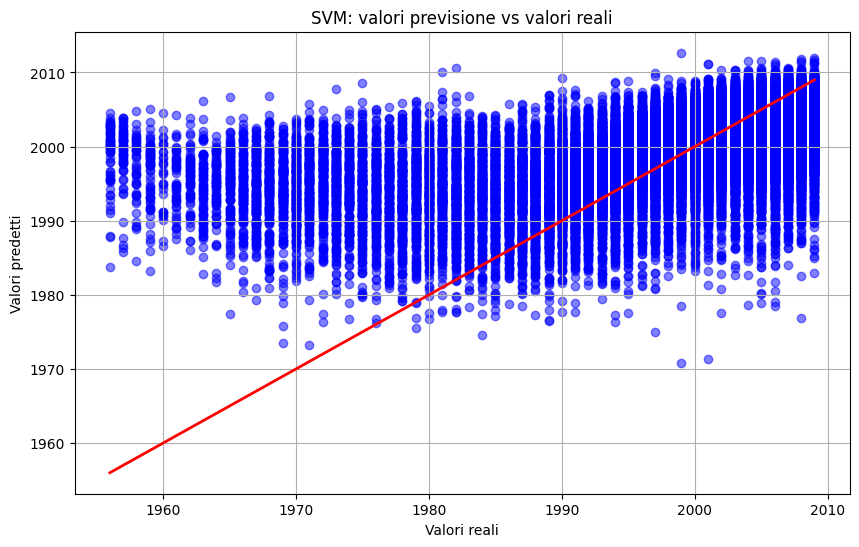

In [16]:

# Definizione del modello SVR con i parametri specifici
svr = SVR(C=0.4, kernel='rbf', gamma='scale', epsilon=0.5)

# Addestramento del modello sui dati di training
svr.fit(X_train_scaled, y_train)

# Predizione sui dati di test
y_pred_svr = svr.predict(X_test_scaled)

# Creazione del grafico Valori previsione vs Valori reali
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svr, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # Linea diagonale
plt.xlabel('Valori reali')
plt.ylabel('Valori predetti')
plt.title('SVM: valori previsione vs valori reali')
plt.grid(True)
plt.show()


In [17]:
# Definizione del modello Random Forest con i parametri specifici
rf = RandomForestRegressor(n_estimators=450, max_depth=170, min_samples_split=8, min_samples_leaf=5, random_state=42)

# Addestramento del modello sui dati di training
rf.fit(X_train_scaled, y_train)

# Predizione sui dati di test
y_pred_rf = rf.predict(X_test_scaled)

# Creazione del grafico Valori previsione vs Valori reali
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # Linea diagonale
plt.xlabel('Valori reali')
plt.ylabel('Valori predetti')
plt.title('RF: valori previsione vs valori reali')
plt.grid(True)
plt.show()
